# 1. Install and Import Dependencies

In [110]:
!pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [111]:
!pip install 'stable-baselines3[extra]' 'protobuf==3.20.*'


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [112]:
!pip install gym mss pyautogui pytesseract


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [113]:
!pip install gymnasium


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [114]:
#chrome://dino/

In [115]:
from mss import mss
import pyautogui
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
from time import sleep
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete 
import re

# 2. Build the Environment

## 2.1 Create Environment

In [116]:
class WebGame(Env):
    ######## THIS SCREEN HOLDS ALL THE INFORMATION ########
    ######### TO UNDERSTAND THE STATE OF THE GAME: ########
    ### TIME_ELAPSED, REMAINING_BALLS_COUNT, SCORE ETC. ###
    entire_screen = {'width':670, 'height':584}
    #####################################################
    
    #### A CONCENTRATED AREA WHERE THERE ARE NO DISTRACTIONS ####
    ###### LIKE SCORE, TIME_ELAPSED, REMAINING_BALLS_COUNT.######
    ################## IT'S A PURE PLAYGROUND ###################
    game_play_screen = {'height':584, 'width':380}
    #####################################################
    
    #### THIS IS THE LOCATION I USE TO UNDERSTAND ####
    ########## IF THE GAME IS OVER OR NOT ############
    ##### (I CHOSED IT TO BE "NEW GAME" button) ######
    gameover_location = {}
    #####################################################
    
    ###### THIS IS THE LOCATION I USE TO UNDERSTAND ######
    ## ELAPSED TIME IN THE GAME REPRESENTED IN SECONDS. ##
    time_location = {}
    #####################################################
    
    ##### COORDINATES OF THE VIDEO GAME #####
    ####### W/ RESPECT TO YOUR SCREEN #######
    # 353: HORIZONTAL MIDDLE POSITION OF GAME SCREEN
    # 690: RIGHT ABOVE THE BALL YOU ARE SHOOTING WITH TO COVER A GOOD SHOOTING ANGLE
    shooting_coordinates = {'x':353, 'y':690}
    start_new_game_coordinates = {'x':353, 'y':540}
    #####################################################
    
    ############ SIZE OF THE STEP TAKEN FOR #############
    ######## 'move_left' AND 'move_right' ACTIONS #######
    steps = 5
    #####################################################
    
    ####### I USE THESE BORDERS AS A WALL SO THAT #######
    ## CURSOR TO CAN NOT GO BEYOND THE GAME PLAYGROUND ##
    wall_borders = {'left':180, 'right':520}
    #####################################################

    rewards = {
        "punishment": {"game_over": 10000},
        "reward": {} 
    }

    ######################## SCREENSHOT LOCATIONS ############################
    ############ Entire_screen includes: Score, game-area, timer, ############
    ### remaining_ball_count, swap_button. The rest of the sections ##########
    ### will be extracted from the Entire_screen with relative positions, ####
    ################### to limit ss actions to 1 per step. ###################
    entire_screen_location = {'top': 170, 'left': 20, 'width': entire_screen['width'], 'height': entire_screen['height']}    
    ################### RELATIVE LOCATION TO entire_screen_location ##########
    game_location = {'top':50 ,'left':290, 'width':800, 'height': 1200}
    gameover_location = {'top':690 ,'left':480, 'width':350, 'height':100}
    score_location = {'top':120 ,'left':10, 'width':220 , 'height': 50}
    time_location = {'top':85 ,'left':1200, 'width':260 , 'height': 70}
    remaining_balls_location = {'top':1050 ,'left':205, 'width':260 , 'height': 1000}
    shooting_bubble_location = {'top':1080 ,'left':540, 'width':260 , 'height': 100}
    bench_bubble_location = {'top':1080 ,'left':920, 'width':260 , 'height': 100}
    ###########################################################################
    
    def __init__(self):
        super().__init__()
        ## DEFINE OBSERVATION SPACE
        self.observation_space = Box(low=0, high=255, shape=(1, self.game_play_screen['height'], self.game_play_screen['width']), dtype=np.uint8)
        
        # move_left, move_right, shoot, swap ball, no-op
        self.action_space = Discrete(5)

        # Capture game frames
        self.cap = mss()
        self.swap_button_location = {'x':475, 'y':730} # DO NOT SWITCH SWAP BUTTON TO RELATIVE POSITIONING
        
        #########################################
        ###### VARIABLES NEEDING reset() ########
        #########################################
        self.action = None
        self.is_board_cleared = False
        self.is_terminated = False
        self.is_truncated = False
        self.previous_score = 0
        self.prev_shot_bubble_color = None
        self.bubble_color = None
        self.bench_bubble_color = None
        self.elapsed_seconds = 0
        self.remaining_balls_count = 35
        self.score = 0
        self.reward = 0
        self.last_shoot_position = {'x': None, 'y': None}
        self.repeating_shots_position = False
        self.entire_screen_ss = [] # has all the game elements in it, including ball_count, score, time_elapsed, get_observation() will reset this in reset()
        self.entire_screen_raw = [] # entire_screen_ss[:,:,:3].astype(np.uint8), get_observation() will reset this in reset()
        self.entire_screen_gray = [] # uses entire_screen_raw, get_observation() will reset this in reset()
        self.game_play_ss = [] # get_observation() will reset this in reset()
        self.observation = [] # get_observation() will reset this in reset()
        #########################################
        
    # Function to move the mouse left
    def move_left(self):
        current_x, current_y = pyautogui.position()
        new_x = max(self.wall_borders['left'], current_x - self.steps)
        pyautogui.moveTo(new_x, self.shooting_coordinates['y'])
    
    # Function to move the mouse right
    def move_right(self):
        current_x, current_y = pyautogui.position()
        new_x = min(self.wall_borders['right'], current_x + self.steps)
        pyautogui.moveTo(new_x, self.shooting_coordinates['y'])

    ## Function to get the color of the shooting bubble
    def get_bubble_color(self):
        bubble_gray = self.entire_screen_gray[self.shooting_bubble_location['top']:self.shooting_bubble_location['top']+self.shooting_bubble_location['height'], self.shooting_bubble_location['left']:self.shooting_bubble_location['left']+self.shooting_bubble_location['width']]
        mid_x = len(bubble_gray) // 2
        mid_y = len(bubble_gray[0]) // 2
        middle_pixel = bubble_gray[mid_x][mid_y]
        self.bubble_color = middle_pixel
        return self.bubble_color

    ## Function to get the color of the bench bubble
    def get_bubble_color_at_bench(self):
        bubble_gray = self.entire_screen_gray[self.bench_bubble_location['top']:self.bench_bubble_location['top']+self.bench_bubble_location['height'], self.bench_bubble_location['left']:self.bench_bubble_location['left']+self.bench_bubble_location['width']]
        mid_x = len(bubble_gray) // 2
        mid_y = len(bubble_gray[0]) // 2
        middle_pixel = bubble_gray[mid_x][mid_y]
        self.bench_bubble_color = middle_pixel
        return self.bench_bubble_color
        
    # Function to perform a click (shoot)
    def shoot(self):
        x, y = pyautogui.position()
        pyautogui.click(x=x, y=y)

        ## update the last_shoot_position to decide whether we have to penalize the algo.
        if self.last_shoot_position['x'] == None and self.last_shoot_position['y'] == None:
            print("first shot!")
            self.last_shoot_position['x'] = x
            self.last_shoot_position['y'] = y
            self.repeating_shots_position = False
        elif self.last_shoot_position['x'] == x and self.last_shoot_position['y'] == y:
            print("shooting from same location")
            self.repeating_shots_position = True
        else:
            print("moved shooting location")
            self.last_shoot_position['x'] = x
            self.last_shoot_position['y'] = y
            self.repeating_shots_position = False

    # Function to swap the shooting ball
    def swap_ball(self):
        x_before_jump, y_before_jump = pyautogui.position()
        pyautogui.click(x=self.swap_button_location["x"], y=self.swap_button_location["y"], button='left')
        pyautogui.moveTo(x=x_before_jump, y=y_before_jump)
    
    # Function to do nothing
    def no_op(self):
        pass  # Perform no action

    def calculate_reward(self):    
        # BASIC REWARD: SCORE CHANGE
        score_reward = self.score - self.previous_score
        approximate_number_of_bubbles_popped = score_reward // 100;
        # Additional reward for popping more bubbles in one shot
        # For instance, if more than 3 bubbles are popped, apply a multiplier
        if approximate_number_of_bubbles_popped > 3:
            print("approximate_number_of_bubbles_popped > 3: ",approximate_number_of_bubbles_popped)
            efficiency_bonus = 1.25
        else:
            efficiency_bonus = 1.0
        # Add to the total_reward
        total_reward = score_reward * efficiency_bonus
        print("reward after determined score: ", total_reward)
        self.previous_score = self.score

        #########################################################
        ######### IF THIS WAS A SHOOT ACTION, PENALIZE ##########
        ###### IF WE SHOT FROM THE SAME LOCATION PREVIOUSLY #####
        ########### WITH THE SAME EXACT COLOR BEFORE ############
        if self.action == 'shoot' and self.repeating_shots_position and self.bubble_color != prev_shot_bubble_color:
            penalty_for_repetition = -50
            total_reward += penalty_for_repetition
            print(f"penalizing for shooting from same position repeatedly by {penalty_for_repetition} reward reduced to: {total_reward}")
        #########################################################

        # the more time elapses the more penalty there is.
        # (because each time it's called the time_elapse will be a higher value)
        # chose this penalty formula to prioritize clearing the board faster.
        # changable it if it doesn't work good. Maybe a fixed value will do fine?
        time_penalty_constant = 100
        total_reward = total_reward - self.elapsed_seconds * time_penalty_constant
        print("reward after time elapsed penalty: ", total_reward)

        ##### IN THE CONTEXT OF THE GAME @https://www.bubbleshooter365.com/ ######
        ### FINISHING EARLY IS NOT GOOD, IT MEANS THAT YOU USED ALL THE BALLS ####
        ############# THAT WERE AVAILABLE TO YOU FROM THE BEGINNING: #############
        if self.is_board_cleared:
            total_reward -= 1000;
            print("reward after is_board_cleared: ",total_reward)

        if self.is_terminated:
            total_reward -= self.rewards["punishment"]["game_over"]
            print("reward after is_terminated: ",total_reward)
            
        # remaining balls punishment: more remains more punishment 
        remaining_balls_reward_constant = 100
        if self.is_terminated and self.remaining_balls_count > 0:
            total_reward -= self.remaining_balls_count * remaining_balls_reward_constant
            print("remaining balls punishment reward: ",total_reward)

        if self.action == 'swap' and self.bench_bubble_color == self.bubble_color:
            penalty_for_swapping_same_ball = -50
            total_reward += penalty_for_swapping_same_ball

        ## MAKE SURE TO UPDATE THE PREV_SHOT_COLOR AFTER SHOOTING IT 
        ## (I WANT TO ASSIGN THE COLOR HERE BECAUSE SOME REWARDS DEPEND ON THEM ABOVE)
        if self.action == 'shoot':
            self.prev_shot_bubble_color = self.bubble_color
        
        self.reward = total_reward
        return self.reward

    def get_remaining_balls_count(self):
        section = self.entire_screen_ss[self.remaining_balls_location['top']:self.remaining_balls_location['top']+self.remaining_balls_location['height'], self.remaining_balls_location['left']:self.remaining_balls_location['left']+self.remaining_balls_location['width']] 
        text = pytesseract.image_to_string(section)
        potential_number_string = self.extract_numbers(text)
        if len(potential_number_string):
            self.remaining_balls_count = int(potential_number_string)
        return self.remaining_balls_count
            
    def step(self, action):
        ### MAP ACTION TO A CORRESPONDING FUNCTION ###
        action_map_fn = {
            0: self.move_left,
            1: self.move_right,
            2: self.shoot,
            3: self.swap_ball,
            4: self.no_op,
        }
        action_map = {
            0: 'move_left',
            1: 'move_right',
            2: 'shoot',
            3: 'swap_ball',
            4: 'no_op',
        }
        ####### SET THE ACTION TAKEN #######
        self.action = action_map[action]
        ####################################
        
        #### PERFORM THE ACTION ####
        ############################
        if action in action_map_fn:
            action_map_fn[action]()
        ############################
        
        ### TODO: REMOVE AFTER EXPERIMENT, 
        ## EXPERIMENTING TO SEE IF GIVING A LITTLE BIT OF TIME FOR GAME
        ## TO SHOW A RESULT FROM THE ACTION (RESPONSE TIME)
        if action_map[action] == 'shoot':
            time.sleep(1.6)

        #### INFORMATION NEEDED TO CALCULATE REWARD ####
        observation = self.get_observation()
        ################################################
        
        #### REWARD IS CALCULATED AFTER OBSERVATION ####
        ################################################
        self.reward = self.calculate_reward()
        info = {}
        truncated = False # not decided how to use this yet.
        return observation, self.reward, self.is_terminated, truncated, info
        ################################################
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Clicking on allegedly "New Game" on the screen
        pyautogui.click(x=self.start_new_game_coordinates['x'], y=self.start_new_game_coordinates['y'], button='left', clicks=1)
        # Positioning cursor to the middle before game starts
        pyautogui.moveTo(x=self.shooting_coordinates['x'], y=self.shooting_coordinates['y']) # move to the center to start the game at the lower center
        info = {}
        self.action = None
        # Should reset the variables that changed after playing one game.
        # remaining_balls_count is a metric, specific to the game @ https://www.bubbleshooter365.com/
        self.remaining_balls_count = 35
        self.last_shoot_position = {'x': None, 'y': None}
        self.prev_shot_bubble_color = None
        self.bubble_color = None
        self.bench_bubble_color = None
        self.repeating_shots_position = False
        self.score = 0
        self.reward = 0
        self.previous_score = 0
        self.elapsed_seconds = 0
        self.is_board_cleared = False
        self.is_terminated = False
        self.is_truncated = False
        ################# UPDATES INSTANCE VARIABLES ##################
        #### NOTE: ORDER MATTERS BECAUSE ONE DEPENDENT ON ANOTHER ##### 
        ############### AND ALL DEPENDENT ON OBSERVATION ##############
        observation = self.get_observation()
        return observation, info
        
    def render(self, area):
        raw = np.array(self.cap.grab(area))[:,:,:3].astype(np.uint8)
        plt.imshow(raw)
         
    def close(self):
        cv2.destroyAllWindows()

    ############# GRABS THE ENTIRE SCREEN INCLUDING: ###########
    ## PLAYGROUND, SCORE, REMAINING_BALLS_COUNT, ELAPSED_TIME ##
    def capture_entire_screen(self):
        self.entire_screen_ss = np.array(self.cap.grab(self.entire_screen_location))
        self.entire_screen_raw = self.entire_screen_ss[:,:,:3].astype(np.uint8)
        self.entire_screen_gray = cv2.cvtColor(self.entire_screen_raw, cv2.COLOR_BGR2GRAY)
    ###############################################################
    
    ################### GRABS ONLY THE PLAYGROUND #################
    def get_gameplay_screen(self):
        self.game_play_ss = self.entire_screen_ss[self.game_location['top']:self.game_location['top']+self.game_location['height'], self.game_location['left']:self.game_location['left']+self.game_location['width']]
        game_play_raw = self.game_play_ss[:,:,:3].astype(np.uint8)
        game_play_gray = cv2.cvtColor(game_play_raw, cv2.COLOR_BGR2GRAY)
        game_play_resized = cv2.resize(game_play_gray, (self.game_play_screen['width'], self.game_play_screen['height']))
        game_play_channel = np.reshape(game_play_resized, (1, self.game_play_screen['height'], self.game_play_screen['width']))
        return self.game_play_ss, game_play_raw, game_play_gray, game_play_resized, game_play_channel
    ###############################################################

    ##### UPDATES VARIABLES THAT DETERMINE THE REWARD. ####
    ###### MEANT TO BE USED AFTER get_observation() #######
    ##########            OR                ###############
    ############# self.capture_entire_screen() ############
    def prepare_reward_metrics(self):
        self.get_remaining_balls_count()
        self.get_is_terminated()
        self.get_is_board_cleared() #### FOR NOW DISABLING IT SINCE THE GAME I AM TRAINING WITH DOESNT NEVER CLEAR, CAN GO ON FOREVER
        self.get_elapsed_seconds()
        self.get_score()
        self.get_bubble_color()
        self.get_bubble_color_at_bench()
        

    ### RETURNS THE OBSERVATION AND UPDATES NECESSARY REWARD METRICS ###
    def get_observation(self):
        ##### CAPTURE THE WHOLE INFORMATION WITH SCREENSHOT #####
        self.capture_entire_screen()
        ###### UPDATE VARIABLES THAT DETERMINE THE REWARD #######
        self.prepare_reward_metrics()
        ################ EXTRACT GAMEPLAY SCREEN ################
        *_, game_play_channel = self.get_gameplay_screen()
        #################### SET OBSERVATION ####################
        self.observation = game_play_channel
        return self.observation

    #### FOR NOW DISABLING IT SINCE THE GAME I AM TRAINING WITH DOESNT NEVER CLEAR, CAN GO ON FOREVER
    def get_is_board_cleared(self):
        if self.is_terminated and self.remaining_balls_count == 0:
            print("finished prematurely")
            self.is_board_cleared = True
            self.is_truncated = True ## it might be a good idea to use is_truncated to reflect a premature game play finish
        return self.is_board_cleared
        
    def get_is_terminated(self):
        terminated_strings = ['Play', 'Now', 'Play Now', 'New', 'Game', 'New Game']
        section = self.entire_screen_raw[self.gameover_location['top']:self.gameover_location['top']+self.gameover_location['height'], self.gameover_location['left']:self.gameover_location['left']+self.gameover_location['width']]
        text = pytesseract.image_to_string(section).strip()
        if text in terminated_strings:
            self.is_terminated = True
            print('game over')
        return self.is_terminated

    def extract_numbers(self, input_string):
        # This regex pattern matches any character that is NOT a digit
        pattern = r'\D'
        # Replace all non-digit characters with an empty string
        return re.sub(pattern, '', input_string)

    def get_score(self):
        section = self.entire_screen_ss[self.score_location['top']:self.score_location['top']+self.score_location['height'], self.score_location['left']:self.score_location['left']+self.score_location['width']]
        text = self.extract_numbers(pytesseract.image_to_string(section))
        if len(text) == 0:
            self.score = 0
        else:
            self.score = int(text)
        return self.score

    def extract_numbers_and_colon(self, that_string):
        # Regular expression pattern: matches digits and colons
        pattern = r'[0-9:]'
        # Find all matches in the string
        matches = re.findall(pattern, that_string)
        # Join matches into a single that_string
        return ''.join(matches)

    def convert_to_seconds(self, timer_str):
        timer_str = self.extract_numbers_and_colon(timer_str)
        timers = timer_str.split(":")
        if len(timers) == 3:
            hours, minutes, seconds = timers
            minutes = int(minutes) + 60 * int(hours)
        elif len(timers) == 2:
            minutes, seconds = timers
        total = int(minutes) * 60 + int(seconds)
        return total
    
    def get_elapsed_seconds(self):
        section = self.entire_screen_ss[self.time_location['top']:self.time_location['top']+self.time_location['height'], self.time_location['left']:self.time_location['left']+self.time_location['width']]
        time = pytesseract.image_to_string(section)
        ######## len(time) == 0 PROBABLY MEANS: #######
        ##### GAME WAS OVER OR NOT STARTED YET. #######
        # THUS RETURNING LAST RECORDED SCORE SO THAT ##
        ## WE DON'T ACCIDENTELY NOT PUNISH THE MODEL.##
        ## WHEN GAME IS OVER time_elapsed will reset ##
        ############## @reset() function ##############
        if not len(time):
            print("can't read the seconds elapsed, returning the previously recorded value: ", self.elapsed_seconds)
            return self.elapsed_seconds
        else:
            self.elapsed_seconds = self.convert_to_seconds(time)
            print("read elapsed_seconds: ", self.elapsed_seconds)
        return self.elapsed_seconds

    # This is a dummy click just so that cursor is switched to the games' browser
    def switch_to_games_browser(self):
        pyautogui.click(x=self.start_new_game_coordinates['x'], y=self.start_new_game_coordinates['y'], button='left', clicks=1)
        

# 2.2 Test Environment

In [132]:
env = WebGame()

shape: (88, 260)
len: 88
middle:  154


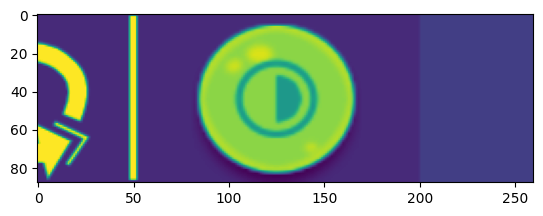

In [175]:
#### This section is mostly used to understand if we captured 
#### the correct frame for each feature
# shooting_bubble_location = {'top':1080 ,'left':540, 'width':260 , 'height': 100}
# bench_bubble_location = {'top':1080 ,'left':920, 'width':260 , 'height': 100}
# env.capture_entire_screen()
# section_gray = env.entire_screen_gray[bench_bubble_location['top']:bench_bubble_location['top']+bench_bubble_location['height'], bench_bubble_location['left']:bench_bubble_location['left']+shooting_bubble_location['width']]
# print("shape:",section_gray.shape)
# print("len:",len(section_gray))
# print("middle: ", section_gray[44][130])
# plt.imshow(section_gray)

## yellow: 154, 
# green: 172.
# blue: 157,
# purple: 142
# 
# print(section)
# done, done_cap = env.get_done()
# print("balls count: ",env.get_elapsed_seconds())
# is_term = env.update_is_terminated()
# print("seconds: ",seconds)

# plt.imshow(raw)
# env.get_remaining_balls_count(entire_screen_raw, cv2.cvtColor(entire_screen_raw, cv2.COLOR_BGR2GRAY))
# print("env.remaining_balls_counts: ",env.remaining_balls_count)

In [138]:
#####################################################################################################
#### THIS IS FOR SANITY CHECKING THE SCREEN POSITIONS OF THE KEY METRICS LIKE SCORE, TIMER ETC.. ####
#####################################################################################################
# swap_button_location = env.swap_button_location # {'x':475, 'y':730}
# entire_screen['width'] = 670
# entire_screen['height'] = 584
# entire_screen_location = {'top': 170, 'left': 20, 'width': entire_screen['width'], 'height': entire_screen['height']}
# env.render(entire_screen_location)


# game_location = env.game_location # {'top': 170, 'left': 184, 'width': env.game_play_screen['width'], 'height': env.game_play_screen['height']}
# score_location = {'top': 232, 'left': 20, 'width': 118, 'height': 20}
# gameover_location = env.gameover_location # {'top': 520, 'left': 260, 'width': 180, 'height': 40}
# time_location = env.time_location # {'top': 200, 'left': 620, 'width': 70, 'height': 60}
# remaining_balls_location = env.remaining_balls_location # {'top':710 ,'left':125, 'width':120 , 'height': 40} {'top':1050 ,'left':205, 'width':260 , 'height': 1000}
# shooting_bubble_location = {'top':1050 ,'left':550, 'width':260 , 'height': 1000}
####################################
#### REMDER ONE AREA AT A TIME. ####
####################################

# # shooting location to pick the color
# print("shooting_bubble_location")
# env.render(shooting_bubble_location)

# # swap button
# pyautogui.click(x=swap_button_location['x'], y=swap_button_location['y'])
# # game play area
# game_location = {'top': 170, 'left': 40, 'width': 400, 'height': entire_screen['height']}
# print("game_location")
# env.render(game_location)
# # score
# print("score_location")
# env.render(score_location)
# # time elapsed
# print("time_location")
# env.render(time_location)
# # remaining balls
# print("remaining_balls_location")
# env.render(remaining_balls_location)
# # # Hit New Game
# print("gameover_location")
# env.render(gameover_location)

In [91]:
#######################################################################################################################
#### EXPERIMENTS CELL: This cell is used for observing how the cursor was moving according to these specifications ####
#######################################################################################################################
# print("starting the game")
# pyautogui.click(x=env.start_new_game_coordinates['x'], y=env.start_new_game_coordinates['y'], button='left', clicks=2, interval=0.25) # click on New Game, clicks twice because first click goes towards selecting the browser
# sleep(1)

# print("moving to shooting point")
# pyautogui.moveTo(x=env.shooting_coordinates['x'], y=env.shooting_coordinates['y'])
# print("peww from center")
# env.click()
# sleep(1)

# print("moving right")
# for i in range(0, 10):
#     sleep(1)
#     env.move_right()
# print("peww from right")
# env.click()

# print("moving left")
# for i in range(0, 20):
#     sleep(1)
#     env.move_left()
# print("peww from left")
# env.click()

# print("swapping balls")
# sleep(1)
# env.swap_ball()


In [92]:
# plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [93]:
# ############################################################
# ### This is just a dummy loop to see the game lifecycle. ###
# ############################################################
# env.switch_to_games_browser()
# env.reset()
# for episode in range(10):
#     obs = env.reset()
#     terminated = False
#     truncated = False
#     total_reward = 0
#     while not (terminated or truncated):
#         obs, reward, terminated, truncated, info =  env.step(env.action_space.sample())
#         print(f'reward: {reward}')
#         total_reward  += reward
#     print('Total Reward for episode {} is {}'.format(episode, total_reward))
    

# 3. Train the Model   

 ## 3.1 Create Callback 

In [94]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [95]:
env_checker.check_env(env)

game over
game over
reward after determined score:  0.0
reward after is_terminated:  -10000.0
remaining balls punishment reward:  -13500.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  300.0
reward after determined score:  0.0
reward after determined score:  0.0


In [96]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [97]:
CHECKPOINT_DIR = '/Volumes/Elements/Tuna/bubble-shooter/train/'
LOG_DIR = '/Volumes/Elements/Tuna/bubble-shooter/logs/'

In [98]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build DQN and Train

In [99]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [100]:
env = WebGame()

In [101]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 532.63GB > 3.05GB
  warnings.warn(


In [102]:
model.learn(total_timesteps=100000, callback=callback)

Logging to /Volumes/Elements/Tuna/bubble-shooter/logs/DQN_1
approximate_number_of_bubbles_popped > 3:  31
reward after determined score:  3937.5
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  300.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined score:  0.0
reward after determined s


KeyboardInterrupt



In [ ]:
model.load('train_first/best_mode l_50000') 

# 4. Test out Model

In [ ]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)